# Quantitative Exercise

The goal of this notebook is to practice quantitative data analysis using Numenta Anomaly Benchmark (NAB) dataset on Streaming Outlier Detection algorithm, in particular on SPOT (add reference). We will use three different datasets comprising of data retrieved from real world. 

In [282]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Load Data

We load the data directly from the csv files in pandas DataFrames, we check if there are some missing values and finally print a sample of the data

In [283]:
df = pd.read_csv('./data/temp_sys_failure.csv')

In [284]:
print("Missing values: ", df.isnull().values.any())

Missing values:  False


In [285]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


## Exploratory Data Analysis

In this section we will explore the data in more detail. Firstly, we will plot data with different view to understand our dataset. Secondly, we will run our dataset over the SPOT algorithm to find outliers and derive more insights
### Descriptive Plotting

Basics dataset statistics

In [286]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


The dataset contains temperature data for a time period of 10 months

In [287]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2013-07-04 00:00:00
2014-05-28 15:00:00


Convert data in the right format, DateTime type and values in Celsius

In [288]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9

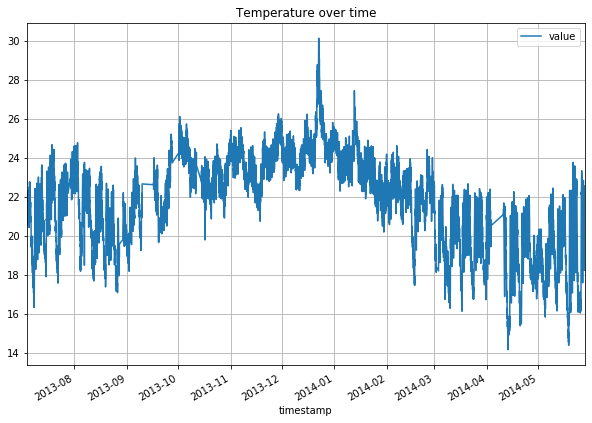

In [289]:
df.plot(x='timestamp', y='value', figsize=(10,7), title='Temperature over time', grid=True)

In [290]:
df = df.set_index('timestamp')
df.index
df.sort_index(inplace=True)

Decomposing time series into components for further analysis, modeled as additive. 

In [307]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive = seasonal_decompose(df, model='additive', freq=5)
additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

,seasonal,trend,resid,actual_values
timestamp,,,,
2013-07-04 00:00:00,0.009319,NaN,NaN,21.044908
2013-07-04 01:00:00,-0.005624,NaN,NaN,21.789015
2013-07-04 02:00:00,-0.006217,21.135758,0.469240,21.598781
2013-07-04 03:00:00,-0.004632,21.155772,-0.618140,20.533000
2013-07-04 04:00:00,0.007154,20.940165,-0.234235,20.713084


Text(0.5, 0.98, 'Additive Decompose')

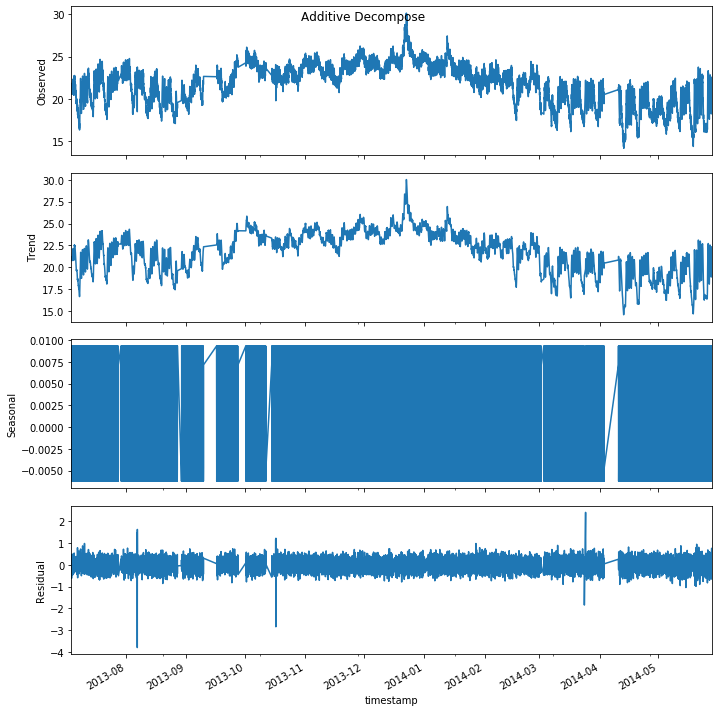

In [308]:
plt.rcParams.update({'figure.figsize': (10,10)})
additive.plot().suptitle('Additive Decompose')

In [311]:
df.reset_index(inplace=True)
df.head()

,timestamp,value
0,2013-07-04 00:00:00,21.044908
1,2013-07-04 01:00:00,21.789015
2,2013-07-04 02:00:00,21.598781
3,2013-07-04 03:00:00,20.533000
4,2013-07-04 04:00:00,20.713084


In [312]:
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head(3)

,value,year,month,day,hour,minute
timestamp,,,,,,
2013-07-04 00:00:00,21.044908,2013,7,4,0,0
2013-07-04 01:00:00,21.789015,2013,7,4,1,0
2013-07-04 02:00:00,21.598781,2013,7,4,2,0


In [320]:
weekly = df['value'].resample('W').mean()
monthly = df['value'].resample('M').mean()
daily = df['value'].resample('D').mean()

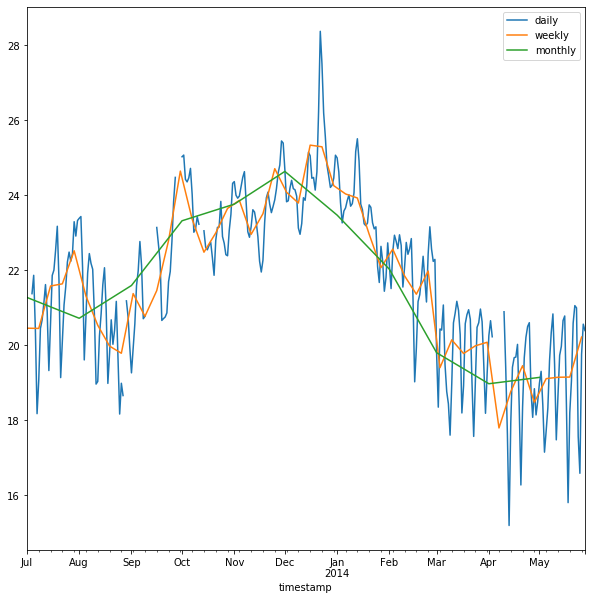

In [327]:
daily.plot()
weekly.plot()
monthly.plot()
plt.legend(["daily", "weekly", "monthly"])